# Import Libraries & Set up the Azure Databricks Environment
The below code is designed to set up the environment in Azure Databricks for big data analytics. It includes imports of various essential Python libraries, such as PySpark, Seaborn, Matplotlib, XGBoost, Pandas, NumPy, and more, which are commonly used for data analysis, visualization, and machine learning. These libraries facilitate data preprocessing, regression analysis, feature selection, and hyperparameter tuning within the Azure Databricks platform, enabling comprehensive big data analytics. Additionally, it configures settings for data visualization and display options, ensuring an optimal environment for data exploration and analysis in the context of big data analytics on the Azure Databricks platform. The interactive shell settings also promote code interactivity, enhancing the user experience in this big data analytics environment.

In [0]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
import seaborn as sns 
from matplotlib.ticker import FormatStrFormatter
from collections import Counter
import heapq
from itertools import compress
import mlflow
import xgboost as xgb

import pandas as pd
import numpy as np
import os, shutil,tempfile
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline


from sklearn.ensemble import RandomForestRegressor as rfs
from sklearn.linear_model import ElasticNet as ens
from sklearn.linear_model import LinearRegression as lrs
from sklearn.linear_model import LassoCV as lcvs
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer

from hyperopt import hp, fmin, tpe, STATUS_OK, SparkTrials, space_eval

from sklearn.pipeline import Pipeline as pipe_s
from sklearn.preprocessing import StandardScaler as sss
from sklearn.preprocessing import MinMaxScaler as mms

from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  

from databricks import automl

from pyspark.mllib.stat import Statistics
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from pyspark.mllib.stat import Statistics

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, UnivariateFeatureSelector, StandardScaler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

%matplotlib inline
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2) 
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Step 1: Data Import & Preprocessing 
The provided code specifies a file's location and type, which is a collection of 2019 American Community Survey 5-year estimates for socio-economic and broadband-related parameters. It loads the data as a DataFrame in a Databricks environment. It applies various data transformations, including selecting relevant columns, changing column names to resolve naming issues, converting numeric data to a percentage representation, and formatting the FIPS code with leading zeros. The code also specifies target and feature columns and narrows down the DataFrame. Finally, it displays the resulting DataFrame for a preliminary examination of data distributions.

In [ ]:
file_location = "/FileStore/tables/USACounty2019ACS5Data.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

#limit columns to those calculated stats 
df = df.select([c for c in df.columns if not c.endswith('E')])

#change the GEOID type to string 
df = df.withColumn("GEOID", F.col("GEOID").cast("string"))

#presence of & in this name causes issues 
df = df.withColumnRenamed("pct_age_65&over","pct_age_65over")

#change the no internet to internet access 
df = df.withColumn('pct_internet', 100 - df['pct_no_internet']).drop(F.col('pct_no_internet'))

#zfill with leading zeros to 5 digits for county FIPS using udf!
df = df.withColumn('FIPS', udf(lambda c: c.zfill(5), StringType())(F.col('GEOID'))).drop(F.col('GEOID'))

#now specify features & target
target = 'pct_internet'

#this is a list of features that should be excluded from predictors since are identical to the target!
excludes = ['pct_internet_no_subscr', 'pct_has_computer_w_diapup_subscr',
    'pct_computer_no_internet_subscr']

features = [c for c in df.columns if all(c!= x for x in ['FIPS', target] + excludes)]

#narrow down the df 
df = df.select(['FIPS'] + features + [target])

#display the df to do some glance at distributions
display(df)

# Step 2: Review Data Schema and Records
The provided code consists of two tasks. First, it displays the first two rows of a DataFrame (df) to validate the record values and data types. Then, it prints the schema of the DataFrame to review the structure of the data, including column names and their corresponding data types. These actions are often performed at the beginning of a data analysis process to gain an initial understanding of the dataset.

In [0]:
#see the first two rows to validate record value and types 
df.limit(2).toPandas()
#and review the data schema
df.printSchema()

,FIPS,pct_age_under_5,pct_age_5to9,pct_age_10to14,pct_age_15to17,pct_age_18to21,pct_age_22to64,pct_age_65over,pct_work_remote,pct_use_pub_trans,income_per_capita,pct_labor_force,pct_unemployed,pct_income_below_poverty,pct_below_bsc,pct_no_insurance,pct_has_a_computer,pct_internet
0,17051,5.50,5.18,6.25,3.73,4.84,55.69,18.82,2.12,0.78,23194.0,52.67,5.65,14.47,88.71,8.24,77.34,74.43
1,17107,5.35,5.09,5.28,3.61,6.02,56.64,18.01,4.91,0.43,27546.0,54.60,5.60,8.24,80.08,4.48,86.72,81.57


root
 |-- FIPS: string (nullable = true)
 |-- pct_age_under_5: double (nullable = true)
 |-- pct_age_5to9: double (nullable = true)
 |-- pct_age_10to14: double (nullable = true)
 |-- pct_age_15to17: double (nullable = true)
 |-- pct_age_18to21: double (nullable = true)
 |-- pct_age_22to64: double (nullable = true)
 |-- pct_age_65over: double (nullable = true)
 |-- pct_work_remote: double (nullable = true)
 |-- pct_use_pub_trans: double (nullable = true)
 |-- income_per_capita: double (nullable = true)
 |-- pct_labor_force: double (nullable = true)
 |-- pct_unemployed: double (nullable = true)
 |-- pct_income_below_poverty: double (nullable = true)
 |-- pct_below_bsc: double (nullable = true)
 |-- pct_no_insurance: double (nullable = true)
 |-- pct_has_a_computer: double (nullable = true)
 |-- pct_internet: double (nullable = true)



# Step 3: Generating a Comprehensive Summary Table for Descriptive Statistics and Missing Values
This code obtains descriptive statistics and information about missing values for a DataFrame (df). First, it calculates quantiles (percentiles) for the columns in the DataFrame using the approxQuantile method. The quantiles include the 10th, 25th, 50th (median), 75th, and 90th percentiles. Then, it combines this quantile information with statistics like mean, count, minimum, and maximum from the original DataFrame by using the describe method. The code also calculates the number of missing values (nulls) for each column in the DataFrame and adds this information to the summary statistics. The result is a summary table that provides statistics, quantiles, and the count of missing values for each column in the DataFrame.

In [0]:
#descibe stats  & # of missing for the df 
#calculate quantiles. using error 0 gets exact quantile which can be expensive!
qs_df = pd.DataFrame(df.approxQuantile(df.columns[1:], [0.1, 0.25, 0.5, 0.75, 0.9], 0), 
                     index = df.columns[1:], columns = [
                         '10th','25th', '50th', '75th', '90th']).T.reset_index().rename(columns = {'index':'summary'})

#add quantiles info to those from oiginal sparks describe (mean, count, min, max)
stat_df  = pd.concat([df.select(df.columns[1:]).describe().toPandas(), qs_df])

#calculate the number of missing 
rows = df.count()

new_row = ['Nulls'] + [rows - int(x) for x in stat_df.iloc[0, 1:]]
stat_df = stat_df.append(pd.Series(new_row, index = stat_df.columns, name = 'x'))
stat_df

,summary,pct_age_under_5,pct_age_5to9,pct_age_10to14,pct_age_15to17,pct_age_18to21,pct_age_22to64,pct_age_65over,pct_work_remote,pct_use_pub_trans,income_per_capita,pct_labor_force,pct_unemployed,pct_income_below_poverty,pct_below_bsc,pct_no_insurance,pct_has_a_computer,pct_internet
0,count,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220,3220
1,mean,5.781074908163417,6.102838583413653,6.416978715380858,3.8847282050083622,5.1246883168574415,53.88637322573899,18.803318045437138,5.049440183375287,0.9073310895290335,27660.94192546584,57.990429627022095,5.543633367279783,13.89197225480473,78.03147693261477,9.549951362717431,84.95026062137477,78.99878648429572
2,stddev,1.2665458975796808,1.23885630539508,1.2210317491013845,0.6867720323417325,2.5728257393970067,3.320726667569647,4.617212186753296,3.2148998771072566,3.0463213934372866,7206.51904782213,8.37506974831806,3.35108411667478,7.282548291921094,9.5007367993206,5.086744845244878,7.193464613480925,8.804220903401797
3,min,0.4247286455875413,0.0,0.0,0.0,0.0,34.16557371805125,3.2007575757575757,0.0,0.0,6118.0,15.365239294710328,0.0,1.8650917003419334,22.442588726513563,0.0,27.188519243313763,24.435746901500323
4,max,21.428571428571427,13.353917406406794,16.455696202531644,9.605263157894736,39.56635823781246,77.27272727272727,56.71443651834554,34.11420204978038,61.243473143367545,76592.0,82.98582151793161,34.11925508286349,60.013892104653856,100.0,46.30177514792899,98.3226266952177,97.51302719764061
0,10th,4.37,4.68,5.02,3.13,3.25,50.03,13.35,2.07,0.0,20232.0,46.61,2.54,7.24,65.41,4.33,76.57,67.47
1,25th,5.04,5.36,5.73,3.53,3.93,52.04,15.86,3.15,0.08,23404.0,52.86,3.64,9.41,74.05,5.75,81.61,74.49
2,50th,5.75,6.06,6.39,3.9,4.6,53.95,18.48,4.38,0.31,27115.0,58.89,4.98,12.39,80.38,8.58,86.09,80.33
3,75th,6.39,6.77,7.04,4.23,5.49,55.79,21.22,6.25,0.73,31095.0,64.1,6.58,16.36,84.59,12.01,89.64,85.04
4,90th,7.11,7.5,7.83,4.59,7.13,57.39,24.66,8.39,1.73,35719.0,67.65,8.7,21.13,87.44,16.24,92.73,89.06


# Step 4: Interactive Feature Distribution Visualization with Databricks Selector Widgets
This code aims to create a dynamic plot using Databricks selector widgets, allowing users to choose two different variables from the available feature sets in the dataset and observe their distributions. It starts by creating dynamic selector widgets for attributes, enabling the user to select specific variables for comparison. It then retrieves the selected attributes, divides the data into 20 bins for each attribute, and counts the frequency of data points within each bin. These histogram counts are stored in the bins_counts list. Subsequently, the code uses Seaborn to generate a bar plot that visualizes the distribution of the selected attributes. The x-axis represents the bins, the y-axis shows the frequency, and bars are colored differently based on the selected attributes. This dynamic visualization provides an alternative to Seaborn's distplot and allows users to interactively explore the dataset's feature distributions using Databricks widgets. 

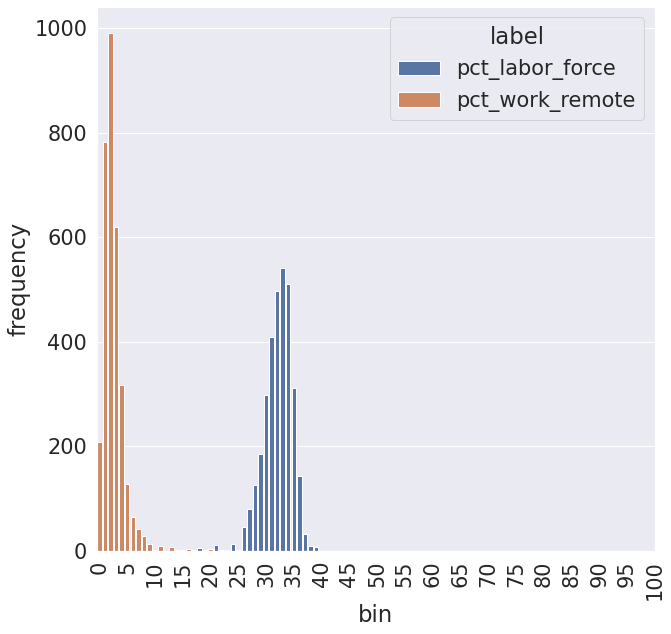

In [0]:
#create dynamic selectors 
dbutils.widgets.multiselect("Attribute", "pct_internet", df.columns[1:])

#use the below code to remove a widget 
#dbutils.widgets.remove("date")

args = getArgument("Attribute").split(',')
bins_counts = [df.select(arg).rdd.flatMap(lambda x: x).histogram(20) for arg in args]
    
#Histogram of Variables
sns.set(font_scale  = 1.9)

_ = plt.figure(figsize = (10, 10))

#this df makes it easy to plot using seaborn
tmp = pd.concat([pd.DataFrame(list(zip(*data)), 
                                    columns = ['bin', 'frequency']).assign(
    label = [label]*len(data[1])) for label, data in zip(args, bins_counts)])

ax = sns.barplot(x = 'bin', y = "frequency", hue = "label", data = tmp, dodge = False)
_ = ax.set_xticks(np.arange(0, 105, 5))
_ = ax.tick_params(axis = 'x', rotation = 90)
_ = ax.xaxis.set_major_formatter(FormatStrFormatter('%.f')) 

# Step 5: Dendrogram-Based Correlation Analysis of Socio-Economic and Broadband Data
This code generates dendrograms to evaluate correlations among various variables using both linear (Pearson) and nonlinear (Kendall) correlation coefficients. The results reveal a strong correlation between the target variable (pct_internet) and computer ownership (pct_has_a_computer), which is logically sensible as broadband usage often occurs through personal computer devices. Additionally, there are relatively strong correlations observed between income (income_per_capita) and the percentage of the population with degrees below a bachelor's (pct_below_bsc), as well as between unemployment (pct_unemployed) and poverty (pct_income_below_poverty). The code begins by setting Seaborn plot variables and creating dynamic selectors for the correlation method. Users can select either Pearson or Kendall correlation. It then calculates and plots the correlation dendrogram, helping to visualize the relationships between the variables based on the chosen correlation method. 

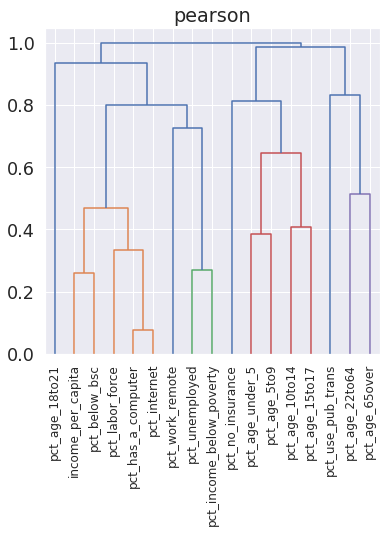

In [0]:
#set seaborn plot variables
_ = sns.set(font_scale  = 1.6)

#create dynamic selectors for method
dbutils.widgets.dropdown("Dendrogram Correlation Method", "pearson", ['pearson', 'spearman'])

#obtain the dynamically selected argument from the dendrogram widget 
method = getArgument("Dendrogram Correlation Method").split(',')

# select variables to analyze
df_features = df.select(df.columns[1:]) 

# create RDD table for correlation calculation
rdd_table = df_features.rdd.map(lambda row: row[0:])

#plot correlation
figure, ax = plt.subplots(ncols = 1, figsize = (6,6))
_ = ax.title.set_text(method[0])
correlations = pd.DataFrame(Statistics.corr(rdd_table, method = method[0]), 
                            index = df.columns[1:], columns = df.columns[1:])

dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')
_ = dendrogram(Z, labels = df.columns[1:], ax = ax,
               orientation = 'top', leaf_rotation = 90)

# Step 6: Stratified Sampling for Addressing Internet Accessibility Disparities in US Counties
The primary objective of this predictive model is to address the digital divide in the United States by focusing on communities with the lowest access to the internet, specifically those falling within the bottom 10th percentile of counties based on the 'pct_internet' parameter. To mitigate bias during model training, a stratified sampling approach is employed, ensuring that disadvantaged counties are proportionally represented in the training, testing, and validation datasets. This prevents the model from overfitting to the majority class (comprising all counties except those in the bottom 10th percentile). Although this is fundamentally a regression problem, a binary 'Class' flag is introduced to identify disadvantaged counties, and the stratified sampling is performed based on this classification. The data is then split into train, test, and validation sets, with the objective of using train and validation data for hyperparameter tuning and the test set for evaluating the final model's performance on unseen data.

In [0]:
#calculate and add the Class
df = df.withColumn('Class', F.when(df["pct_internet"] <= stat_df[
    stat_df.summary == '10th'].pct_internet.values[0], 1).otherwise(0))

#now slipt the data into train, test, validation sets  
zeros, ones = df.filter(df["Class" ] == 0), df.filter(df["Class" ] == 1)

#now split 70, 20, 10 for train, test, and validation
train0, valid0, test0 = zeros.drop(*('FIPS')).randomSplit([0.7, 0.2, 0.1], seed = 123)
train1, valid1, test1  = ones.drop(*('FIPS')).randomSplit([0.7, 0.2, 0.1], seed = 123)

#now union each segment. Train/valid are used in hypeor param tuning, and test set used at final tuned model test (unseen)!
trainDF, validDF, testDF = train0.union(train1), valid0.union(valid1), test0.union(test1) 

# Step 7: Data Preparation for PySpark Machine Learning Training Datasets
This code segment prepares datasets for machine learning training in PySpark by following label conventions, selecting specific features, and handling missing values using dropna(). It creates three datasets for training, validation, and testing, each containing the labeled data, selected features, and the "Class" column. These datasets are organized into a dictionary for easy access in subsequent pipeline steps. Additionally, it calculates and stores the counts of data points in each of these datasets for later reference.

In [0]:
#create the datasets
lr_datasets = {type: data.select(F.col(target).alias("label"), *features, 'Class').dropna() for type, data in zip(
    ['train', 'valid', 'test'], [trainDF, validDF, testDF])}
#create dataset counts
lr_data_counts = {k: v.count() for k,v in lr_datasets.items()}

#convert them to pandas dataframes for further exploratory data analysis
pdf_train = lr_datasets['train'].sampleBy('Class', {0:1, 1:1}, 1234).toPandas()
pdf_valid = lr_datasets['valid'].sampleBy('Class', {0:1, 1:1}, 1234).toPandas()
pdf_test = lr_datasets['test'].sampleBy('Class', {0:1, 1:1}, 1234).toPandas()

pdf_train.head(1)

,label,pct_age_under_5,pct_age_5to9,pct_age_10to14,pct_age_15to17,pct_age_18to21,pct_age_22to64,pct_age_65over,pct_work_remote,pct_use_pub_trans,income_per_capita,pct_labor_force,pct_unemployed,pct_income_below_poverty,pct_below_bsc,pct_no_insurance,pct_has_a_computer,Class
0,82.79,5.81,6.89,6.5,4.65,4.67,56.53,14.96,3.41,0.66,29819.0,58.94,3.61,12.58,73.43,7.07,89.25,0


# Step 8: Visualize Inspection of Histograms
In this step, histogams of target and predictors are plotted for visual inspection for outliers and normality. The non-normal distribution of variables, including both the target and some explanatory variables, suggests the presence of outliers in the dataset, which manifest as long right or left tails in the distributions. It's important to note that the Random Forest regressor model can be sensitive to outliers, potentially resulting in reduced predictive performance when outliers are present. Therefore, an evaluation of the impact of feature transformation on model performance is warranted to address this issue.

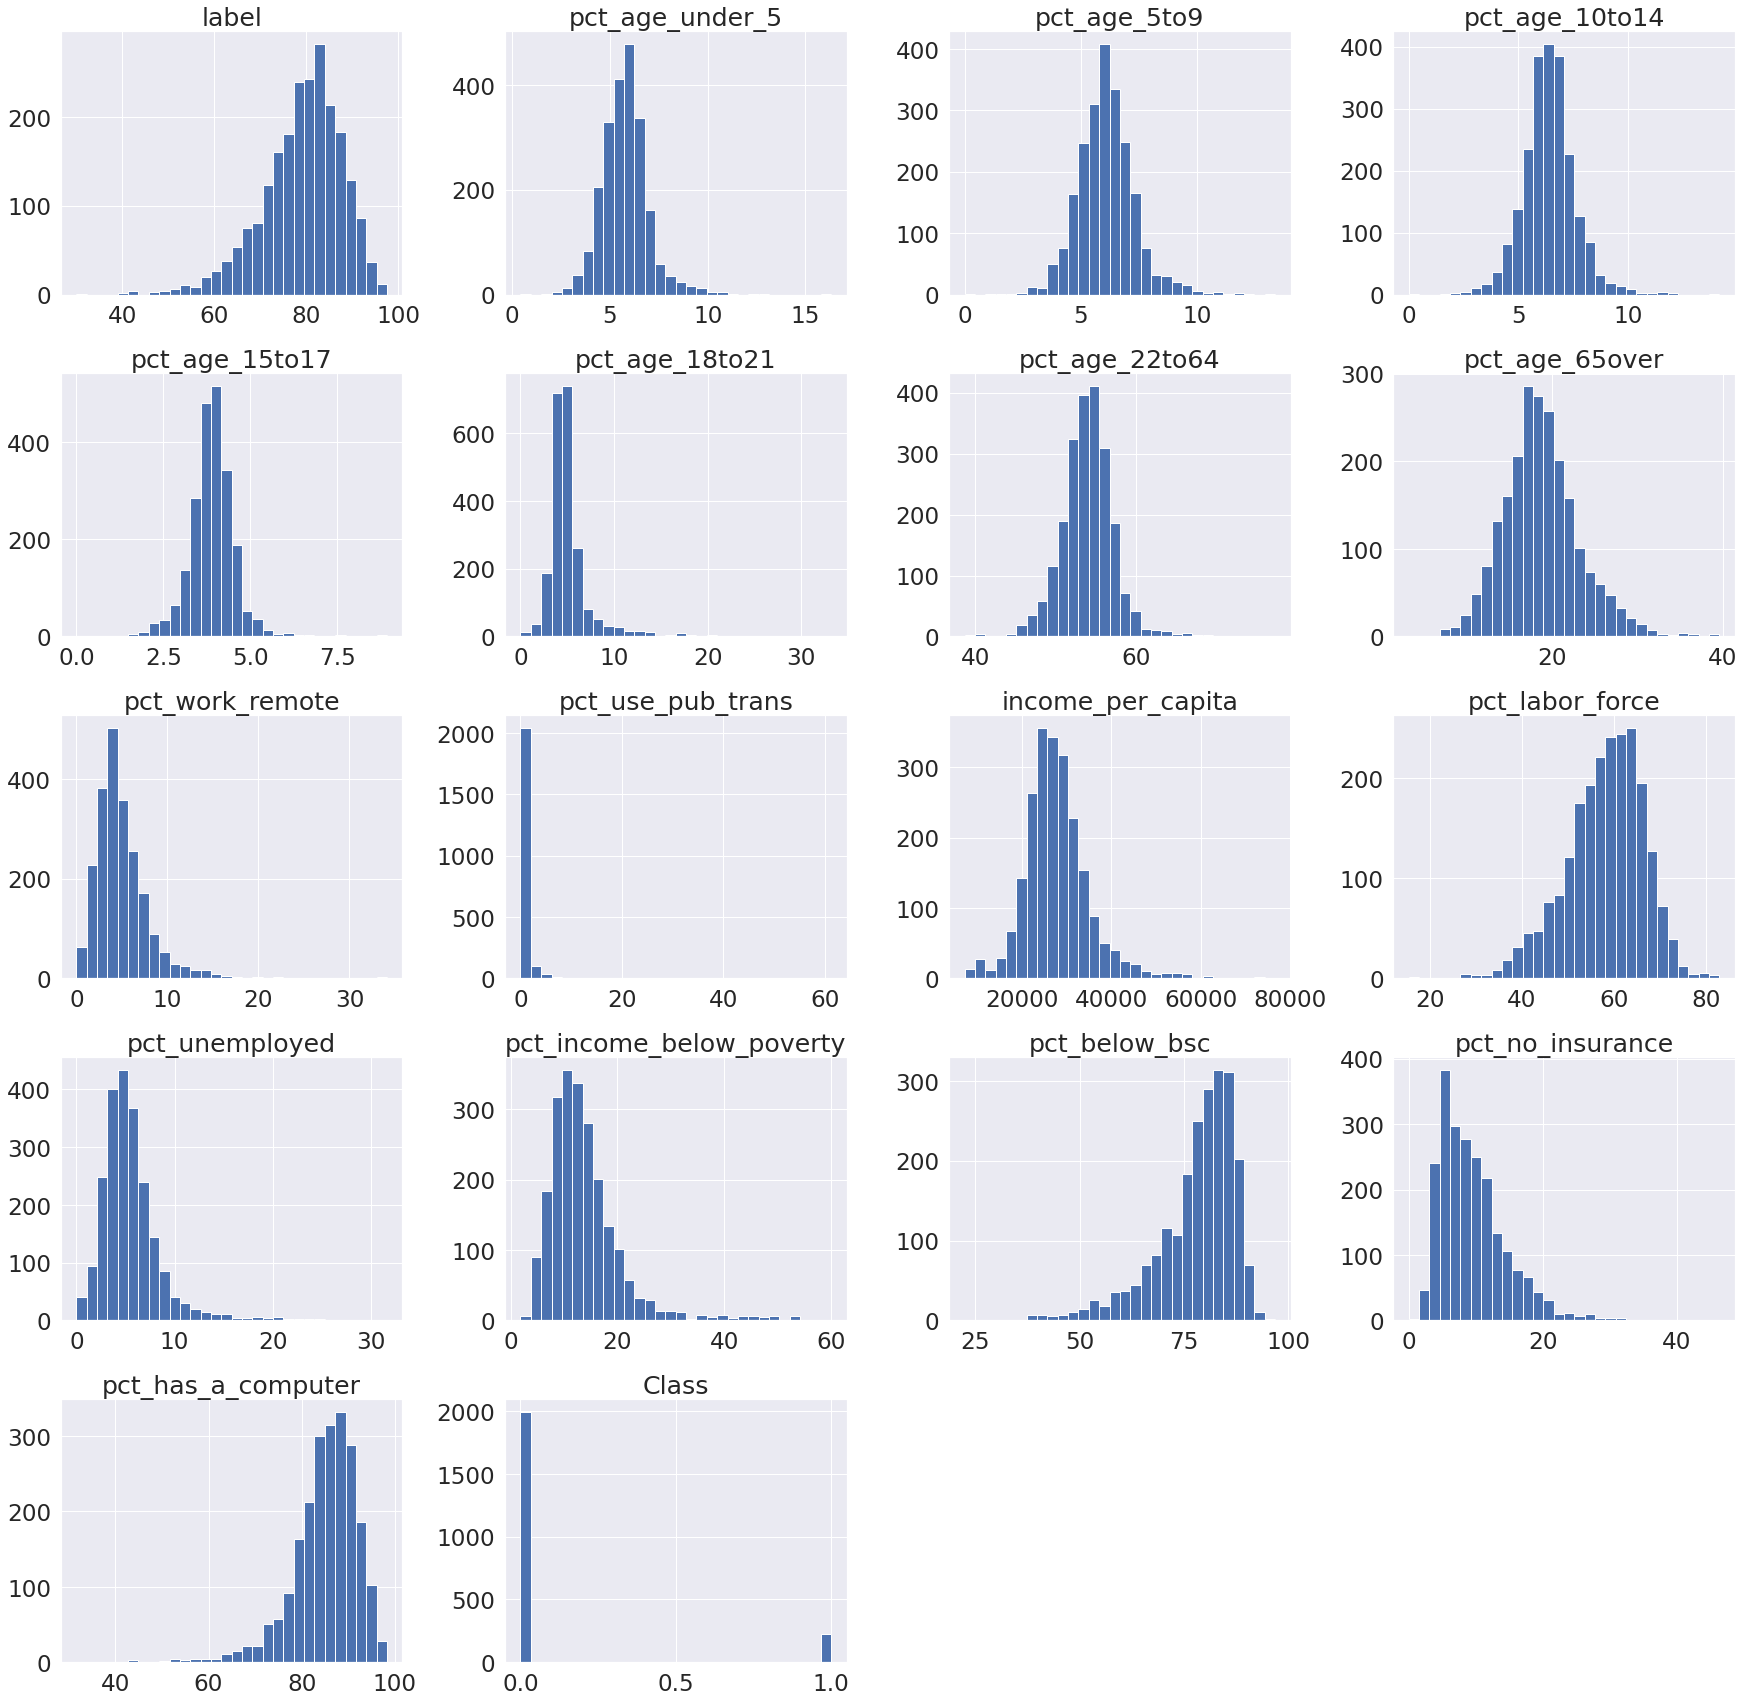

In [0]:
sns.set(font_scale = 2.1)

#plot histograms of the train set
_=pdf_train.hist(bins = 30, figsize=(30, 30))

# Step 9: Evaluating the Impact of Data Transformation on Regression Model Performance  
In this section, the impact of data transformation on model performance is assessed. An Elastic Net regressor with default parameters serves as a baseline for evaluating the effects of data and model enhancements. Notably, both scaled and unscaled cases yield an adjusted R-squared (R2) of 0.89, indicating a strong fit for the model. The model using income-scaled data is preferred because income values are substantially larger than other variables, which can affect regression model weights. The section includes data scaling functions, model evaluation functions, and the training of the Elastic Net regressor with various data transformations: unscaled features, MinMax-scaled income, standardized features, and standardized features with the label. Model performance results for each case are reported, providing insights into the impact of these transformations on model effectiveness.

In [0]:
def scaler(df, cols, fn = mms()):
    """
    This function applies a specific preprocessing on a pandas dataframe

    INPUTS:
    df: The pandas dataframe that contains the datasets that should be scaled
    cols: df columns to scale 
    fn: the scaler function which should be imported from sklearn's preprocessing module
    OUTPUTS: 
    a dataframe with scaled features
    """
    
    df[cols] = fn.fit_transform(df[cols])
    return df

def eval_model(model, X, y):
    
    """
    This function evaluates a regresson model 

    INPUTS:
    model: The model to be evaluated 
    X: a Pandas dataframe containing the explianatory variables
    y: a Pandas dataframe containing the target variable
    OUTPUTS: 
    a dictonary containing evaluation metrics such as MSE, RMSE, MAE, and adjusted R2 
    """
    
    y_pred = model.predict(X)
    return {
        'mse': mean_squared_error(y, y_pred),
        'rmse': np.sqrt(mean_squared_error(y, y_pred)),
        'mae': mean_absolute_error(y, y_pred),
        'adj_rsquared': 1 - (1-r2_score(y, y_pred))*(len(y)-1)/(len(y)-X.shape[1]-1)
    }
    

#train the the model with the original (unscaled) data
ens_unscald = ens(random_state=1234).fit(pdf_train[features], pdf_train['label'])
print('results for unscaled features: %s'%eval_model(ens_unscald, pdf_valid[features], pdf_valid['label']))
   
#train the the model with minmax scaled data
pdf_train_scaled = scaler(pdf_train.drop(columns = ['Class']), ['income_per_capita'])
pdf_valid_scaled = scaler(pdf_valid.drop(columns = ['Class']), ['income_per_capita'])
ens_scaled = ens(random_state=1234).fit(pdf_train_scaled[features], pdf_train_scaled['label'])
print('results for only minmax scaled income: %s'%eval_model(ens_scaled, pdf_valid_scaled[features], pdf_valid_scaled['label']))      

#train the the model with standardized all features
pdf_train_standardized = scaler(pdf_train.drop(columns = ['Class']), features, fn = sss())
pdf_valid_standardized = scaler(pdf_valid.drop(columns = ['Class']), features, fn = sss())
ens_standardized = ens(random_state=1234).fit(pdf_train_standardized[features], pdf_train_standardized['label'])
print('results for standardzied all features: %s'%eval_model(ens_standardized, pdf_valid_standardized[features], pdf_valid_standardized['label']))  

#train the the model with standardized all features and the label
pdf_train_standardized_all = scaler(pdf_train.drop(columns = ['Class']), features + ['label'], fn = sss())
pdf_valid_standardized_all = scaler(pdf_valid.drop(columns = ['Class']), features + ['label'], fn = sss())
ens_standardized_all = ens(random_state=1234).fit(pdf_train_standardized_all[features], pdf_train_standardized_all['label'])
print('results for standardzied all features and the label: %s'%eval_model(ens_standardized_all, pdf_valid_standardized_all[features], pdf_valid_standardized_all['label']))  

results for unscaled features: {'mse': 8.449696604260106, 'rmse': 2.906836184627559, 'mae': 2.1500860254307983, 'adj_rsquared': 0.8943314742388064}
results for only minmax scaled income: {'mse': 8.477406412338924, 'rmse': 2.911598600827203, 'mae': 2.1469377515952903, 'adj_rsquared': 0.893984946463201}
results for standardzied all features: {'mse': 16.36633619865727, 'rmse': 4.045532869555909, 'mae': 2.9610597082729786, 'adj_rsquared': 0.7953291462142853}
results for standardzied all features and the label: {'mse': 0.546661016107506, 'rmse': 0.7393652792142095, 'mae': 0.5622388697820271, 'adj_rsquared': 0.44016642928749405}


# Step 10: Assessing the Impact of Standardization on XGBoost Regressor Performance¶
The impact of standardization on XGBoost Regressor performance was assessed, revealing that standardization slightly improved its results. Consequently, the decision was made to standardize the feature set for XGBoost. The XGBoost Regressor was trained on both minmax scaled income and standardized features, and their performance was evaluated. The results showed that standardization led to improved performance for the XGBoost Regressor, emphasizing the benefits of standardization for this model. 

In [0]:
xgbr = xgb.XGBRegressor(random_state = 1234)
xgbr_scaled = xgbr.fit(pdf_train_scaled[features], pdf_train_scaled['label'])
print('xgb regressor results for only minmax scaled income: %s'%eval_model(xgbr_scaled, 
                                                                           pdf_valid_scaled[features], 
                                                                           pdf_valid_scaled['label']))  

xgbr_standardized = xgbr.fit(pdf_train_standardized[features], pdf_train_standardized['label'])
print('xgb regressorresults for standardzied all X features: %s'%eval_model(xgbr_standardized, 
                                                                            pdf_valid_standardized[features], 
                                                                            pdf_valid_standardized['label'])) 

xgb regressor results for only minmax scaled income: {'mse': 10.452922594970971, 'rmse': 3.2330979872207664, 'mae': 2.2927639005755505, 'adj_rsquared': 0.8692799313114307}
xgb regressorresults for standardzied all X features: {'mse': 10.141990600940906, 'rmse': 3.1846492115994356, 'mae': 2.271123110641538, 'adj_rsquared': 0.8731683224525493}


# Step 11: Analyzing the Relationship Between Selected Variables and Internet Access Using Partial Dependence Plots and Individual Conditional Expectation
In this section, the discussion centers on One-dimensional Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots, which are now supported in older versions of sklearn. The aim is to gain insights into the relationships between specific socioeconomic explanatory variables and internet access in each US county. The results reveal that computer ownership has a linear and consistently impactful relationship with internet access across various levels of computer ownership. Meanwhile, the effect of income on internet access varies with income range; it positively influences access for incomes below $30,000 per year but stabilizes at over 80% for incomes above this threshold. Education and insurance ownership show uniform, linear relationships with internet access across their respective value ranges. ICE plots help identify nonlinear patterns that can differ across target variable ranges, highlighting deviations from the average PDP trend. Note that these plots were not available on the Databricks community version at the time this project was compiled. Therefore, it was run seperately on the local desktop and interpretation of resuls were added. 

In [0]:
features_of_interest = getArgument("Attribute").split(',')
def plot_pdp_ice(model, train_X, features_of_interest):
    """
    This function creates Partial Dependence Plots (PDP) 

    INPUTS:
    model: The model to be evaluated 
    train_X: a Pandas dataframe containing the explianatory variables
    features_of_interest: features that we would like to plot
    OUTPUTS: 
    The output is a plot based on the selected features
    """
    sns.set(font_scale = 1.1)
    display  = PartialDependenceDisplay.from_estimator(model, train_X, features_of_interest, 
                                                       kind = 'both', random_state = 42,
                                                       n_jobs = -1, subsample = 100, 
                                                       ice_lines_kw = {"color": "tab:blue", 
                                                                       "alpha": 0.2, "linewidth": 0.5},
                                                       pd_line_kw = {"color": "tab:orange", 
                                                                     "linestyle": "--"})
    display.figure_.set_figwidth(15)
    display.figure_.set_figheight(7)

_ = plot_pdp_ice(ens_scaled, pdf_train_scaled[features], features_of_interest)

# Step 12: Exploring Interactions Between Pairs of Predictor Variables and Their Impact on Internet Access Through Two-Dimensional Partial Dependence Plots
In this section, Two-dimensional Partial Dependence Plots (PDP) are explored. These plots address a limitation of one-dimensional PDPs and ICE plots by revealing the relationships between pairs of predictor variables and their combined impact on the target variable. While Random Forest models can handle multicollinearity, visualizing the joint influence of features is valuable for research purposes. The two-dimensional PDP is illustrated with average lines for income and education features, and scatter plots of actual data points are included to pinpoint interpretable areas. The results demonstrate a nonlinear pattern where an increase in income and a decrease in the population with low education (below a bachelor's degree) lead to higher internet access. Additionally, the variation in internet access due to income significantly diminishes for incomes exceeding $30,000. Note that these plots were not available on the Databricks community version at the time this project was compiled. Therefore, it was run seperately on the local desktop and interpretation of resuls were added.

In [0]:
def plot_pdp_2d(rf, train_X, features_of_interest):
    
    """
    This function creates Partial Dependence Plots (PDP) 

    INPUTS:
    model: The model to be evaluated 
    train_X: a Pandas dataframe containing the explianatory variables
    features_of_interest: features that we would like to plot
    OUTPUTS: 
    The output is a plot based on the selected features
    """
    
    x1 = features_of_interest[0]; x2 = features_of_interest[1]
    sns.set(font_scale=1.2)
    features_of_interest = features_of_interest + [(x1, x2)]
    display  = PartialDependenceDisplay.from_estimator(rf, train_X, features_of_interest, 
                                                       kind = 'average', random_state = 42,
                                                       n_jobs = -1, subsample = 100, 
                                                       ice_lines_kw = {"color": "tab:blue", 
                                                                       "alpha": 0.2, "linewidth": 0.5},
                                                       pd_line_kw = {"color": "tab:orange", 
                                                                     "linestyle": "--"})
    _ = plt.scatter(train_X[x1],train_X[x2], alpha = 0.05, color = 'black')
    display.figure_.set_figwidth(16)
    display.figure_.set_figheight(7)

# Step 13: Feature Selection 
In this section, a comprehensive exploration of feature selection methods is undertaken, resulting in a final selection of the top 5 most significant features. A variety of techniques are applied to identify these key features, and a majority voting approach is employed to combine the results from the different methods, ensuring robustness and reliability in the final feature selection process.

In [0]:
#this list will store all suggested features by all methods below! 
best_features = []

## Step 13-1: Feature Selection Using Filtering the Pearson correlation coefficients
In this section, the feature selection process employs a filtering approach using Pearson correlation coefficients. Features are chosen based on a defined correlation threshold, where only those with an absolute correlation coefficient greater than 0.6 with the target variable are retained. The identified features are then added to the list of best features, providing a valuable subset for further analysis.

In [0]:
fm_features = list(compress(correlations.index , abs(correlations[target]) > 0.6))[:-1]
best_features.append(fm_features)
print(fm_features)

['income_per_capita', 'pct_labor_force', 'pct_income_below_poverty', 'pct_below_bsc', 'pct_has_a_computer']


## Step 13-2: Feature Selection Using Recursive Feature Elimination (RFE)
In section 4.6.2, feature selection methods using model wrappers are introduced, which rely on a baseline model to either eliminate or include features. The Backward Elimination (BE) approach is similar to the permutation importance method and focuses on the top 4 selected features. On the other hand, Recursive Feature Elimination (RFE) evaluates coefficients from a specified model and iteratively removes low-importance variables (those with the smallest coefficients) until the desired number of variables, in this case, 5, is achieved. These methods help refine the selection of important features for subsequent analysis.

In [0]:
estimator = ens(random_state = 1234)
rfe = RFE(estimator, n_features_to_select = 5, step=1)
rfe = rfe.fit(pdf_train_scaled[features], pdf_train_scaled['label'])
rfe_features = list(compress(features, rfe.support_))
best_features.append(rfe_features)
print(rfe_features)

['pct_labor_force', 'pct_income_below_poverty', 'pct_below_bsc', 'pct_no_insurance', 'pct_has_a_computer']


In [0]:
#Backward Elimination (BE)
cols = features.copy()
while (len(cols) > 0):
    X_1 = pdf_train_scaled[cols]
    #Adding constant column of ones, mandatory for sm.OLS model
    X_1 = sm.add_constant(X_1)
    #Fitting sm.OLS model
    ols_model = sm.OLS(pdf_train_scaled.label,X_1).fit()
    p = pd.Series(ols_model.pvalues.values[1:],index = cols)      
    if(max(p)>0.05):
        _ = cols.remove(p.idxmax())
    else:
        break
best_features.append(cols)       
print(cols)

['pct_age_10to14', 'pct_labor_force', 'pct_below_bsc', 'pct_no_insurance', 'pct_has_a_computer']


## Step 13-3: Feature Selection Using the Random Forest Model
In this section, the focus is on feature selection using the Random Forest model. The feature importance scores provided by Random Forest are leveraged to identify high-impact features, reducing model complexity and mitigating the risk of overfitting. The analysis revealed that computer ownership, insurance ownership, education, and income are the top four most influential predictors of internet access. As anticipated, computer ownership stands out as the most significant predictor, while the other mentioned factors contribute to a lesser extent to the prediction of internet access.

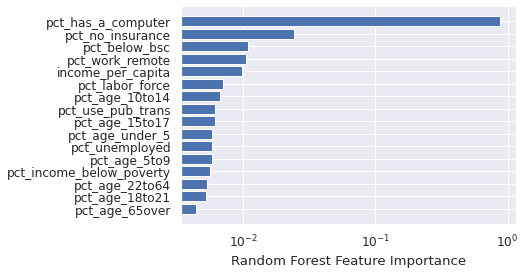

In [0]:
#this plots feature importance using random forest selector
def plot_featurce_importance(rfmodel, features, log_scale = False): 
    
    """
    This function plots feature importance based on Random Forest

    INPUTS:
    model: The Random Forest model to be evaluated 
    features: features that we would like to include
    OUTPUTS: 
    The output is a plot based on the selected features
    """
    
    sns.set(font_scale = 1.1)
    sorted_idx = rfmodel.feature_importances_.argsort()
    sorted_features = [features[i] for i in sorted_idx]
    _ = plt.barh(sorted_features, rfmodel.feature_importances_[sorted_idx], log = log_scale)
    _ = plt.xlabel("Random Forest Feature Importance")
    return sorted_features

rf_features = plot_featurce_importance(rfs(random_state=1234).fit(pdf_train_scaled[features],
                                                                  pdf_train_scaled.label), 
                                       features, log_scale = True)
best_features.append(rf_features[::-1][:5])

## Step 13-4: Feature Selection Using Permutation Importance
In this section, feature selection is explored using Permutation Importance, addressing certain issues associated with Impurity-Based methods like Random Forest's Feature Importance. These issues pertain to overemphasizing high-cardinality features, including rare or unique ones, potentially prioritizing noise over essential explanatory variables. Unlike the model-specific Feature Importance, Permutation Importance is model-agnostic and assesses the influence of each feature on the model's performance on the test set, taking into account its generalization capacity. The top four most crucial predictors identified through the permutation importance method were in alignment with the feature importance model, with some minor variations in rankings. 

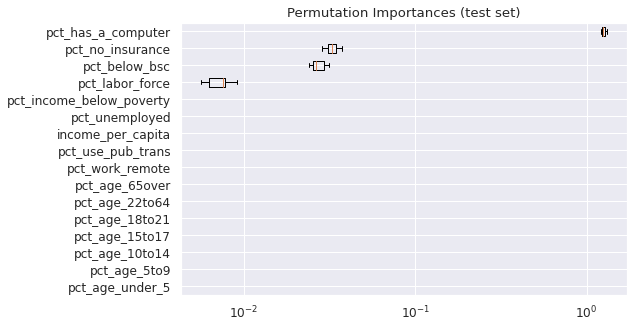

In [0]:
def plot_permutation_importance(model, test_X, test_y, log_scale = False):   
    
    """
    This function creates permutation importance plots

    INPUTS:
    model: The model to be evaluated 
    test_X: a Pandas dataframe containing the explianatory variables
    test_y: a Pandas dataframe containing the target variable
    log_scale: flag to indicate the log scale 
    OUTPUTS: 
    The output is a permutation importance plot 
    """
    
    sns.set(font_scale = 1.1)
    result = permutation_importance(
        model, test_X, test_y, n_repeats = 10, random_state = 42, n_jobs = -1
    )
    sorted_idx = result.importances_mean.argsort()
    fig, ax = plt.subplots(figsize = (8,5))
    _ = ax.boxplot(result.importances[sorted_idx].T, 
                   vert = False, labels = test_X.columns[sorted_idx]
    )
    _ = ax.set_title("Permutation Importances (test set)")
    if log_scale:
        ax.set_xscale("log")
    return test_X.columns[sorted_idx]
#use elastic net model of sklearn 
pi_features = plot_permutation_importance(ens_scaled, pdf_valid_scaled[features], 
                                          pdf_valid_scaled['label'], log_scale = True)
best_features.append(pi_features[::-1][:5])

## Step 13-5: Feature Selection Using the Lasso Model 
In this section, Lasso Regularization is employed as a feature selection method. Lasso has the capability to shrink the coefficients of unimportant features down to zero, effectively eliminating them from the model. This quality makes Lasso an effective feature selection tool, as it helps identify and retain only the most relevant features for modeling and prediction.

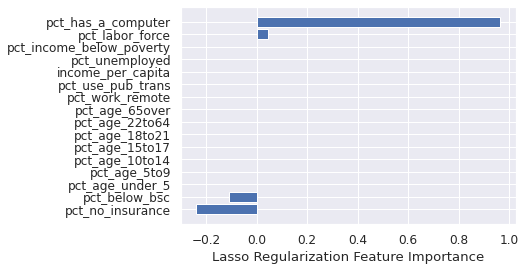

In [0]:
def plot_lasso_importance(l_model, features): 
    
    """
    This function creates lasso feature importance plots

    INPUTS:
    l_model: The lasso model to be used 
    features: features to be evaluated
    OUTPUTS: 
    The output is a lasso feature importance plot 
    """
    
    sns.set(font_scale = 1.1)
    sorted_idx = l_model.coef_.argsort()
    sorted_features = [features[i] for i in sorted_idx]
    _ = plt.barh(sorted_features, l_model.coef_[sorted_idx])
    _ = plt.xlabel("Lasso Regularization Feature Importance")
    return sorted_features

#build a lasscv model
lcvs_model = lcvs(random_state=1234).fit(pdf_train_scaled[features], pdf_train_scaled.label)
lasso_features = plot_lasso_importance(lcvs_model, features)
lcvs_features = [features[i] for i, coef in enumerate(lcvs_model.coef_) if abs(coef)>0]
best_features.append(lcvs_features)

## Step 13-6: Finalizing Feature Selection Using the Majority Voting from Multiple Methods
In this section, feature selection is summarized through a Majority Voting approach. This process involves utilizing various feature selection methods, and the final selection of the best features is determined by identifying the top 5 features that receive the highest number of votes across all the applied methods.

In [0]:
best_dict = Counter([x for y in best_features for x in y])
top_features = heapq.nlargest(5, best_dict, key = best_dict.get)
print(top_features)
#also calculate exclude cols that no longer are used for further steps
exclude_cols = [c for c in features if all(c not in x for x in top_features)]

['pct_below_bsc', 'pct_has_a_computer', 'pct_labor_force', 'pct_no_insurance', 'pct_income_below_poverty']


# Step 14: Data Transformation
In this section, a transformer pipeline is created and fitted based on the prior Exploratory Data Analysis (EDA) results. The feature selection strategy and scaling method have been finalized. This pipeline includes a column transformer for feature selection, using the selected top features, and a standard scaler for data standardization. After setting up the transformation logic, the pipeline is fitted, enabling its use in subsequent modeling steps. The transformed data includes training, validation, and test sets, while the target variables remain unaltered.

In [0]:
#build a column transformer that selects best features
col_selector = ColumnTransformer([("selector", "passthrough", top_features)], 
                                 remainder="drop")
#build a sklearn standardscaler! 
standardizer = sss()

# package transformation logic
transform = pipe_s([
   ('col_selector', col_selector),
   ('standardizer', standardizer)
   ])

#fit it once that all transformer steps are ready for final pipeline use 
X_train = transform.fit_transform(pdf_train)
X_valid = transform.fit_transform(pdf_valid)
X_test = transform.fit_transform(pdf_test)

#also create y sets! No scaling needed on y! 
y_train = pdf_train.label
y_valid = pdf_valid.label
y_test  = pdf_test.label

# Step 15: Model Selection Using AutoML in Databricks 
Automated methods involve optimizing a variety of models on the dataset and saving the results, allowing the user to compare and choose the desired model. Two popular automated methods are PyCaret and AutoML in Databricks. AutoML is simpler and performs experiment saving using MLFlow, suitable for big data projects as it employs models implementable in PySpark. Here, AutoML is initially used to assess model performance, followed by a deeper exploration of the best options. The original Spark dataframe (trainDF) is utilized since income per capita is not a predictor, and scaling was not found to be beneficial for other fields.

The models included in AutoML are Linear Regression with Stochastic Gradient Descent (LR with SGD), Decision Tree (DT), Random Forest (RF), LightGBM, and XGBoost (XGB). The training data is cached due to multiple accesses, and the count of the test dataset is evaluated. Additionally, a display of the training data is provided to offer a closer look at the dataset.

Following the AutoML process, it was determined that the XGBoost Regressor achieved the highest validation set R-squared (R2) value of 0.913, positioning it as the best model. LightGBM and the Stochastic Gradient Linear Regressor secured the second and third places, respectively, after XGBoost. The next step involves training the Spark implementations of these models on the complete train/test dataset using hyperparameter optimization techniques.

In [ ]:
print(trainDF.cache().count()) # Cache because accessing training data multiple times
print(testDF.count())
display(trainDF)

In [0]:
summary = automl.regress(trainDF, target_col = "pct_internet", 
                         exclude_columns = exclude_cols, 
                         timeout_minutes = 30)

2022/08/15 14:18:00 INFO databricks.automl.supervised_learner: AutoML run for regression started with run_id: 4936a138-9850-436c-9ec5-8a8b47dcec5d
2022/08/15 14:18:00 WARNING databricks.automl.supervised_learner: Parameter exclude_columns is deprecated and will be removed in a future Databricks Runtime release. Please use exclude_cols instead.
2022/08/15 14:18:01 INFO databricks.automl.base_learner: AutoML run for regression will record all trials to MlFlow experiment with id: 2842597465952454
2022/08/15 14:18:06 WARNING databricks.automl.preprocess: Semantic type `categorical` detected for column `Class`. Training notebooks will encode features based on categorical transformations.
2022/08/15 14:18:06 WARNING databricks.automl.preprocess: Semantic type `numeric` detected for column `FIPS`. Training notebooks will convert each column to a numeric type and encode features based on numerical transformations.
2022/08/15 14:18:37 INFO databricks.automl.supervised_learner: Data exploration 

,Train,Validation,Test
r2_score,0.908,0.910,0.882
mae,1.951,2.028,2.023
score,0.908,0.910,0.882
rmse,2.644,2.752,2.777
mse,6.991,7.576,7.713


2022/08/15 14:48:13 INFO databricks.automl.base_learner: AutoML run with experiment id: 2842597465952454 succeeded.


# Step 16: Fine Tuning the XBG Regressor
A hyperparameter tuning process for the XGBoost Regressor was conducted using Hyperopt. The search space included hyperparameters like 'max_depth,' 'alpha,' 'colsample_bytree,' 'learning_rate,' and 'n_estimators.' The model was trained and evaluated using the specified hyperparameters, and the evaluation involved mean absolute error (MAE) and adjusted R-squared (adj_r2) as the metrics. The results were logged using MLflow, with a maximum of 100 iterations for hyperparameter tuning. The best parameters for the XGBoost Regressor were determined using this process, providing insights into the model's optimal configuration. 

In [0]:
# define list to hold run ids for later retrieval
run_ids = []

# Hyperopt search space
space_xgbreg = {'max_depth': hp.quniform('max_depth', 4, 16, 1)
        ,'alpha' : hp.uniform('alpha', 1, 10)
        ,'colsample_bytree' : hp.uniform('colsample_bytree', 0.1, 1)
        ,'learning_rate' : hp.uniform('learning_rate', 0.1, 1)
        ,'n_estimators': hp.quniform('n_estimators', 25, 500, 25)
        ,'tree_method': 'auto'     
}

def train_and_eval_xgbreg(space):

    """
    Trains a regressor using training data with the input alpha and evaluates it using test data.
    INPUTS:
    space: parameter space

    OUTPUTS: 
    loss and status of the evaluation 
    """
    
    #since no preprocessing is needed, no pipeline is needed to use
    xgbreg = xgb.XGBRegressor(objective ='reg:squarederror' 
                            ,n_estimators = int(space['n_estimators'])
                            ,colsample_bytree = space['colsample_bytree']
                            ,learning_rate = space['learning_rate']
                            ,max_depth = int(space['max_depth'])
                            ,alpha = space['alpha']
                            ,tree_method= space['tree_method'])
    
    # Load data
    eval_set  = [(X_train, y_train),(X_valid, y_valid)]

    # Train. eval_set has tuples of (X,y) for which validation is done!
    #here we use both train and valid sets
    _ = xgbreg.fit(X_train, y_train, eval_set = eval_set, eval_metric = "mae",
            early_stopping_rounds = 10, verbose = False)
    
    # Validate
    pred = xgbreg.predict(X_valid)
    mae_scr = mean_absolute_error(y_valid, pred)
    adjr2_scr = 1 - (1-r2_score(y_valid, pred))*(len(pred) - 1)/(len(pred)-len(top_features) - 1)
    
    mlflow.log_metric('mae', mae_scr)  # record mae
    mlflow.log_metric('adj_r2', adjr2_scr)  # record adjusted r2
    
    return {'loss': mae_scr, 'status': STATUS_OK}

def objective_large_xgbreg(space):
    
    """
    this function trains and evaluate the XGB regressor based on the objective function 
    INPUTS:
    space: parameter space

    OUTPUTS: 
    results of the model evaluation 
    """
    
    # Load data back from DBFS onto workers
    data = load(data_large_path)   
    return train_and_eval_xgbreg(space)


def tune_xgbr(objective, max_evals = 10, parallelism = None):
    
     """
    this function uses Hyperopt's SparkTrials to tune the input objective
    INPUTS:
    objective: the objective function 
    max_evals: max number of evaluation 
    parallelism: a boolean to indicate use parallelism or not 

    OUTPUTS: 
    teturns the best parameters found
    """
    
    trials = SparkTrials(parallelism = parallelism)
    
    # Hyperopt & mlflow 
    # perform evaluation
    with mlflow.start_run(run_name = 'XGB Regressor'):   
        argmin = fmin(
        fn = objective
        ,space = space_xgbreg
        ,algo = tpe.suggest  # algorithm controlling how hyperopt navigates the search space
        ,max_evals = max_evals
        ,trials = trials # depends on the # of workers in a gpu-enabled cluster (guidance differs for CPU-based clusters)
        ,verbose = True
        )
    return argmin

#i.e., argmin
best_params_xgbr = tune_xgbr(objective_large_xgbreg, max_evals = 100)     
print('xgbr model was tuned!')

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]/databricks/spark/python/pyspark/rdd.py:980: FutureWarning: Deprecated in 3.1, Use pyspark.InheritableThread with the pinned thread mode enabled.
  warnings.warn(

100%|██████████| 2/2 [00:13<00:00,  6.56s/trial, best loss: 2.3553416748725815]
xgbr model was tuned!
temporary DFBS data are deleted as training is done!


# Step 17: Hyperparameter Tuning and Training of XGBoost Regressor for Persistence in Production
The hyperparameter tuning process using Hyperopt was carried out for the XGBoost Regressor, resulting in optimal hyperparameters. Subsequently, a persistence model was trained with these optimal settings for later use in production. The configuration parameters were captured and logged with MLflow. The model was trained on the combined training and validation sets, and its predictions on the test set were recorded. The evaluation metrics, mean absolute error (MAE), and adjusted R-squared (adj_r2) were logged using MLflow. The model was logged and saved for future use in production. The final model achieved an adjusted R-squared score of 0.88, which was noted for reference.

In [0]:
# train model with optimal settings 
with mlflow.start_run(run_name='Persistent XGBRegressor') as run:
    # capture run info for later use
    run_id = run.info.run_id
    run_name = run.data.tags['mlflow.runName']
    run_ids += [(run_name, run_id)]

    # configure params
    params = space_eval(space_xgbreg, best_params_xgbr)
    if 'max_depth' in params: params['max_depth'] = int(params['max_depth'])   
    if 'n_estimators' in params: params['n_estimators'] = int(params['n_estimators'])     
    params['tree_method']='hist'        # modified for CPU deployment
    params['predictor'] = 'cpu_predictor' # modified for CPU deployment
    _ = mlflow.log_params(params)

    #train the persistent model on train + valid 
    #model = XGBClassifier(**params)
    xgbreg = xgb.XGBRegressor(**params)
    X_train_full = np.concatenate([X_train, X_valid])
    y_train_full = np.concatenate([y_train, y_valid])

    _ = xgbreg.fit(X_train_full, y_train_full)
    _ = mlflow.sklearn.log_model(xgbreg, 'model')  # persist model with mlflow

    # predict the test set
    #y_prob = model.predict_proba(X_test)
    pred = xgbreg.predict(X_test)
    # scores
    mae_scr = mean_absolute_error(y_test, pred)
    adjr2_scr = 1 - (1-r2_score(y_test, pred))*(len(pred) - 1)/(len(pred)-len(top_features) - 1)
    
    _ = mlflow.log_metric('mae', mae_scr)  # record mae
    _ = mlflow.log_metric('adj_r2', adjr2_scr)  # record adjusted r2

    print('The persistent XGBRegressor logged under run_id "{0}" with adjusted r2 score of {1:.5f}'.format(run_id, adjr2_scr))

The persistent XGBRegressor logged under run_id "639beacadfd843f1a946a07690ba5dba" with adjusted r2 score of 0.87928


# Step 18: Registering the Final Model for Production Deployment
The final model is registered with the MLflow model registry. The registration process is monitored until the newly registered model transitions from the 'PENDING_REGISTRATION' status to 'READY.' Once the model reaches the 'READY' status, it is moved to the 'production' stage in the model registry.

In [ ]:
model_name = 'xgbregressor-persistent'

# archive any production model versions (from any previous runs of this notebook or manual workflow management)
client = mlflow.tracking.MlflowClient()

for mv in client.search_model_versions("name='{0}'".format(model_name)):
    # if model with this name is marked production
    if mv.current_stage.lower() == 'production':
      # mark is as archived
      client.transition_model_version_stage(
        name = mv.name,
        version = mv.version,
        stage='archived'
        )
      
# register last deployed model with mlflow model registry
mv = mlflow.register_model(
    'runs:/{0}/model'.format(run_id),
    'socioeconomic-regressor'
    )
model_version = mv.version

# wait until newly registered model moves from PENDING_REGISTRATION to READY status
while mv.status == 'PENDING_REGISTRATION':
    
    time.sleep(5)
    for mv in client.search_model_versions("run_id='{0}'".format(run_id)):  # new search functionality in mlflow 1.10 will make easier
        if mv.version == model_version:
            break
      
# transition newly deployed model to production stage
client.transition_model_version_stage(
  name=model_name,
  version=model_version,
  stage='production'
  )      